# Studying and Forecasting web traffic using Python and GridDB

In the last few years, the time-series database category has experienced the fastest growth. Both established and emerging technology sectors have been producing an increasing amount of time-series data.

The quantity of sessions in a given period of time is known as web traffic, and it varies greatly depending on the time of day, day of the week, and other factors. The amount of web traffic a platform can handle is determined by the size of the servers that host the platform.

Based on historical visitor volume data or historical web traffic data, you can dynamically allocate many servers. And that brings us to the data science challenge, which is basically analysing and forecasting the volume of sessions or web traffic based on past data.

The outline of the tutorial is as follows:

 1. Dataset overview
 2. Importing required libraries
 3. Loading the dataset
 4. Analysing with data visualization
 5. Forecasting
 6. Conclusion

# Prerequisites and Environment setup

This tutorial is carried out in Anaconda Navigator (Python version – 3.8.5) on Windows Operating System. The following packages need to be installed before you continue with the tutorial –

1. Pandas

2. NumPy

3. re

4. Matplotlib

5. Seaborn

6. griddb_python

7. fbprophet

You can install these packages in Conda’s virtual environment using `conda install package-name`. In case you are using Python directly via terminal/command prompt, `pip install package-name` will do the work.

### GridDB installation

While loading the dataset, this tutorial will cover two methods – Using GridDB as well as Using Pandas. To access GridDB using Python, the following packages also need to be installed beforehand:

1. [GridDB C-client](https://github.com/griddb/c_client)
2. SWIG (Simplified Wrapper and Interface Generator)
3. [GridDB Python Client](https://github.com/griddb/python_client)

# 1. Dataset Overview

The  dataset consists of approximately 145k time series. Each of these time series represent a number of daily views of a different Wikipedia article, starting from July, 1st, 2015 up until December 31st, 2016. 

https://www.kaggle.com/competitions/web-traffic-time-series-forecasting/data

# 2. Importing Required Libraries


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import seaborn as sns
from fbprophet import Prophet
import griddb_python as griddb

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

# 3. Loading the Dataset

Let’s proceed and load the dataset into our notebook.


## 3.a Using GridDB

Toshiba GridDB™ is a highly scalable NoSQL database best suited for IoT and Big Data. The foundation of GridDB’s principles is based upon offering a versatile data store that is optimized for IoT, provides high scalability, tuned for high performance, and ensures high reliability.


To store large amounts of data, a CSV file can be cumbersome. GridDB serves as a perfect alternative as it in open-source and a highly scalable database. GridDB is a scalable, in-memory, No SQL database which makes it easier for you to store large amounts of data. If you are new to GridDB, a tutorial on  [reading and writing to GridDB](https://griddb.net/en/blog/using-pandas-dataframes-with-griddb/)  can be useful.

Assuming that you have already set up your database, we will now write the SQL query in python to load our dataset.

The read_sql_query function offered by the pandas library converts the data fetched into a panda data frame to make it easy for the user to work.

In [ ]:
sql_statement = ('SELECT * FROM train_1.csv)
df1 = pd.read_sql_query(sql_statement, cont)

Note that the `cont` variable has the container information where our data is stored. Replace the `credit_card_dataset` with the name of your container. More info can be found in this tutorial [reading and writing to GridDB](https://griddb.net/en/blog/using-pandas-dataframes-with-griddb/).

When it comes to IoT and Big Data use cases, GridDB clearly stands out among other databases in the Relational and NoSQL space.
Overall, GridDB offers multiple reliability features for mission-critical applications that require high availability and data retention.

## 3.b  Using pandas read_csv

We can also use Pandas' `read_csv` function to load our data. Both of the above methods will lead to the same output as the data is loaded in the form of a pandas dataframe using either of the methods.

In [2]:
df = pd.read_csv('train_1.csv', parse_dates=True) 

In [3]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


# 4. Analysing with data visualization

Is Traffic Influenced by Page Language?

How the various languages used in Wikipedia might affect the dataset is one thing that might be interesting to examine. I'll search for the language code in the wikipedia URL using a straightforward regular expression.

In [4]:
train_1 = df

In [5]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return 'na'

train_1['lang'] = train_1.Page.map(get_language)

from collections import Counter

print(Counter(train_1.lang))

Counter({'en': 24108, 'ja': 20431, 'de': 18547, 'na': 17855, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})


In [6]:
lang_sets = {}
lang_sets['en'] = train_1[train_1.lang=='en'].iloc[:,0:-1]
lang_sets['ja'] = train_1[train_1.lang=='ja'].iloc[:,0:-1]
lang_sets['de'] = train_1[train_1.lang=='de'].iloc[:,0:-1]
lang_sets['na'] = train_1[train_1.lang=='na'].iloc[:,0:-1]
lang_sets['fr'] = train_1[train_1.lang=='fr'].iloc[:,0:-1]
lang_sets['zh'] = train_1[train_1.lang=='zh'].iloc[:,0:-1]
lang_sets['ru'] = train_1[train_1.lang=='ru'].iloc[:,0:-1]
lang_sets['es'] = train_1[train_1.lang=='es'].iloc[:,0:-1]

sums = {}
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:,1:].sum(axis=0) / lang_sets[key].shape[0]

So then how does the total number of views change over time? I'll plot all the different sets on the same plot.

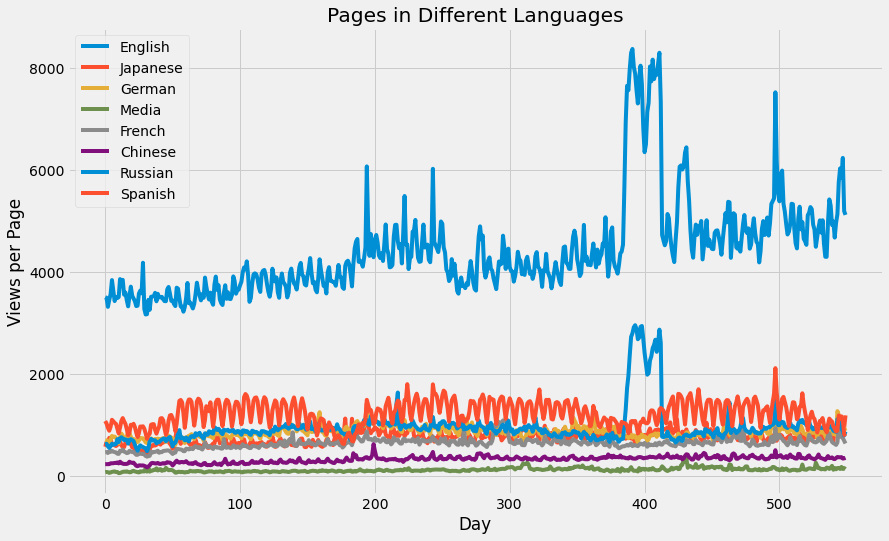

In [7]:
days = [r for r in range(sums['en'].shape[0])]

fig = plt.figure(1,figsize=[13,8])
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title('Pages in Different Languages')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }

for key in sums:
    plt.plot(days,sums[key],label = labels[key] )
    
plt.legend()
plt.show()

English shows a much higher number of views per page, as might be expected since Wikipedia is a US-based site. 

In [8]:
df1 = df.T
df1 = df1.reset_index()

In [10]:
df1.head()

,Date,2NE1_zh.wikipedia.org_all-access_spider,2PM_zh.wikipedia.org_all-access_spider,3C_zh.wikipedia.org_all-access_spider,4minute_zh.wikipedia.org_all-access_spider,52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider,5566_zh.wikipedia.org_all-access_spider,91Days_zh.wikipedia.org_all-access_spider,A'N'D_zh.wikipedia.org_all-access_spider,AKB48_zh.wikipedia.org_all-access_spider,...,Drake_(músico)_es.wikipedia.org_all-access_spider,Skam_(serie_de_televisión)_es.wikipedia.org_all-access_spider,Legión_(serie_de_televisión)_es.wikipedia.org_all-access_spider,Doble_tentación_es.wikipedia.org_all-access_spider,Mi_adorable_maldición_es.wikipedia.org_all-access_spider,Underworld_(serie_de_películas)_es.wikipedia.org_all-access_spider,Resident_Evil:_Capítulo_Final_es.wikipedia.org_all-access_spider,Enamorándome_de_Ramón_es.wikipedia.org_all-access_spider,Hasta_el_último_hombre_es.wikipedia.org_all-access_spider,Francisco_el_matemático_(serie_de_televisión_de_2017)_es.wikipedia.org_all-access_spider
1,2015-07-01,18.0,11.0,1.0,35.0,NaN,12.0,NaN,118.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-07-02,11.0,14.0,0.0,13.0,NaN,7.0,NaN,26.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-07-03,5.0,15.0,1.0,10.0,NaN,4.0,NaN,30.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-07-04,13.0,18.0,1.0,94.0,NaN,5.0,NaN,24.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2015-07-05,14.0,11.0,0.0,4.0,NaN,20.0,NaN,29.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df1=df1[:550]

In [ ]:
column_header = df1.iloc[0,:].values

df1.columns = column_header
    
df1 = df1.drop(0, axis = 0)
df1 = df1.rename(columns = {"Page" : "Date"})

In [18]:
df1["Date"] = pd.to_datetime(df1["Date"], format='%Y-%m-%d')
df1 = df1.set_index("Date")

In [19]:
# Finding number of access types and agents
access_types = []
agents = []
for column in df1.columns:
    access_type = column.split("_")[-2]
    agent = column.split("_")[-1]
    access_types.append(access_type)
    agents.append(agent)

In [20]:
# Counting access types
from collections import Counter
access_dict = Counter(access_types)
access_dict

Counter({'all-access': 74315, 'desktop': 34809, 'mobile-web': 35939})

In [21]:
access_df = pd.DataFrame({"Access type" : access_dict.keys(),
                          "Number of columns" : access_dict.values()})
access_df

,Access type,Number of columns
0,all-access,74315
1,desktop,34809
2,mobile-web,35939


In [22]:
agents_dict = Counter(agents)
agents_dict

Counter({'spider': 34913, 'all-agents': 110150})

In [23]:
agents_df = pd.DataFrame({"Agent" : agents_dict.keys(),
                          "Number of columns" : agents_dict.values()})
agents_df

,Agent,Number of columns
0,spider,34913
1,all-agents,110150


In [24]:
df1.columns[86543].split("_")[-3:]
"_".join(df1.columns[86543].split("_")[-3:])

projects = []
for column in df1.columns:
    project = column.split("_")[-3] 
    projects.append(project)

In [25]:
project_dict = Counter(projects)
project_df = pd.DataFrame({"Project" : project_dict.keys(),
                           "Number of columns" : project_dict.values()})

project_df

,Project,Number of columns
0,zh.wikipedia.org,17229
1,fr.wikipedia.org,17802
2,en.wikipedia.org,24108
3,commons.wikimedia.org,10555
4,ru.wikipedia.org,15022
5,www.mediawiki.org,7300
6,de.wikipedia.org,18547
7,ja.wikipedia.org,20431
8,es.wikipedia.org,14069


In [26]:
def extract_average_views(project):
    required_column_names = [column for column in df1.columns if project in column]
    average_views = df1[required_column_names].sum().mean()
    return average_views

average_views = []
for project in project_df["Project"]:
    average_views.append(extract_average_views(project))

In [27]:
project_df["Average views"] = average_views
project_df['Average views'] = project_df['Average views'].astype('int64')


In [28]:
project_df

,Project,Number of columns,Average views
0,zh.wikipedia.org,17229,184107
1,fr.wikipedia.org,17802,358264
2,en.wikipedia.org,24108,2436898
3,commons.wikimedia.org,10555,99429
4,ru.wikipedia.org,15022,532443
5,www.mediawiki.org,7300,31411
6,de.wikipedia.org,18547,477813
7,ja.wikipedia.org,20431,419523
8,es.wikipedia.org,14069,674546


In [29]:
project_df_sorted = project_df.sort_values(by = "Average views", ascending = False)

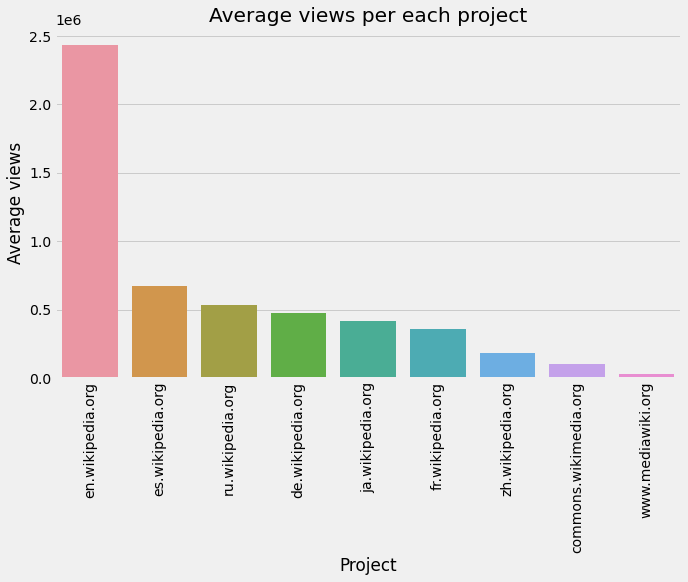

In [30]:
plt.figure(figsize = (10,6))
sns.barplot(x = project_df_sorted["Project"], y = project_df_sorted["Average views"])
plt.xticks(rotation = "vertical")
plt.title("Average views per each project")
plt.show()

Popular pages in "en.wikipedia.org"

<AxesSubplot:xlabel='Date'>

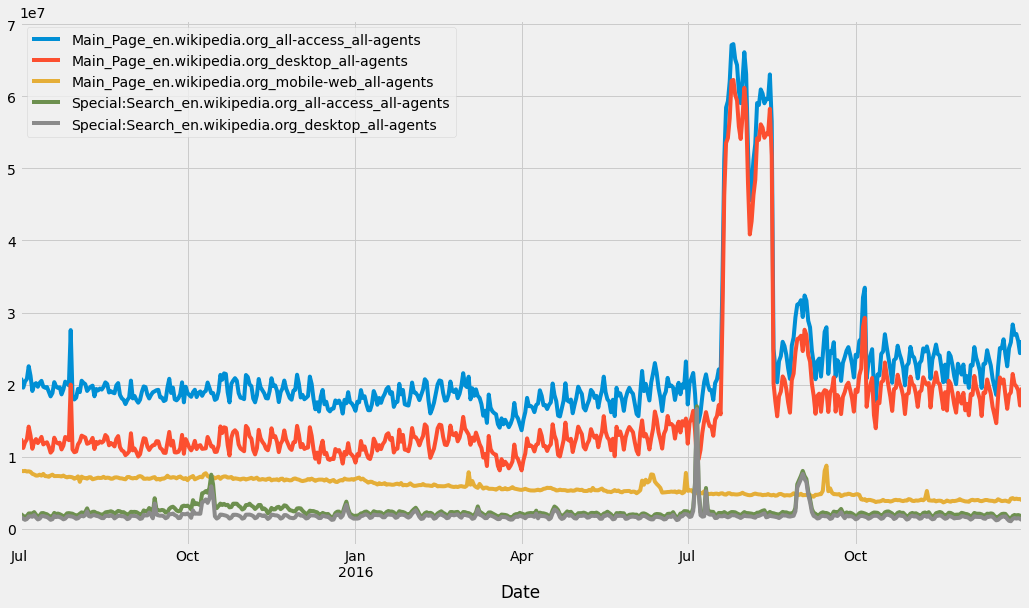

In [31]:
en_wikipedia_org_columns = [column for column in df1.columns if "en.wikipedia.org" in column]

top_pages_en = df1[en_wikipedia_org_columns].mean().sort_values(ascending = False)[0:5]
df1[top_pages_en.index].plot(figsize = (16,9))

# 5. Forecasting

In [39]:
train = df

In [40]:
train

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,lang
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0,zh
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0,zh
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0,zh
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0,zh
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0,zh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145058,Underworld_(serie_de_películas)_es.wikipedia.o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,13.0,12.0,13.0,3.0,5.0,10.0,es
145059,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,es
145060,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,es
145061,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,es


In [41]:
train=pd.melt(df[list(df.columns[-50:])+['Page']], id_vars='Page', var_name='date', value_name='Visits')

In [52]:
list1 = ['lang']
train = train[train.date.isin(list1) == False]

In [53]:
train

,Page,date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,2016-11-13,8.0
1,2PM_zh.wikipedia.org_all-access_spider,2016-11-13,11.0
2,3C_zh.wikipedia.org_all-access_spider,2016-11-13,4.0
3,4minute_zh.wikipedia.org_all-access_spider,2016-11-13,13.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2016-11-13,11.0
...,...,...,...
7108082,Underworld_(serie_de_películas)_es.wikipedia.o...,2016-12-31,10.0
7108083,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,2016-12-31,NaN
7108084,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,2016-12-31,NaN
7108085,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,2016-12-31,NaN


In [54]:
train['date'] = train['date'].astype('datetime64[ns]')
train['weekend'] = ((train.date.dt.dayofweek) // 5 == 1).astype(float)
median = pd.DataFrame(train.groupby(['Page'])['Visits'].median())
median.columns = ['median']
mean = pd.DataFrame(train.groupby(['Page'])['Visits'].mean())
mean.columns = ['mean']

train = train.set_index('Page').join(mean).join(median)
train.reset_index(drop=False,inplace=True)
train['weekday'] = train['date'].apply(lambda x: x.weekday())

train['year']=train.date.dt.year 
train['month']=train.date.dt.month 
train['day']=train.date.dt.day

<ipython-input-54-a04de4fcca9a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['date'] = train['date'].astype('datetime64[ns]')
<ipython-input-54-a04de4fcca9a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['weekend'] = ((train.date.dt.dayofweek) // 5 == 1).astype(float)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData

C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData

C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData

C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData

C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData

C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData

C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData

C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData

C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData

C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData

C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData

C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData

C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData

C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData

C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData

C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData

C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData

C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Aayush Mittal\AppData

In [55]:
mean_g = train[['Page','date','Visits']].groupby(['date'])['Visits'].mean()

means =  pd.DataFrame(mean_g).reset_index(drop=False)
means['weekday'] =means['date'].apply(lambda x: x.weekday())

means['Date_str'] = means['date'].apply(lambda x: str(x))

#create new columns year,month,day in the dataframe bysplitting the date string on hyphen and converting them to a list of values and add them under the column names year,month and day
means[['year','month','day']] = pd.DataFrame(means['Date_str'].str.split('-',2).tolist(), columns = ['year','month','day'])

#creating a new dataframe date by splitting the day column into 2 in the means data frame on sapce, to understand these steps look at the subsequent cells to understand how the day column looked before this step
date = pd.DataFrame(means['day'].str.split(' ',2).tolist(), columns = ['day','other'])
means['day'] = date['day']*1

In [56]:
means.drop('Date_str',axis = 1, inplace =True)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


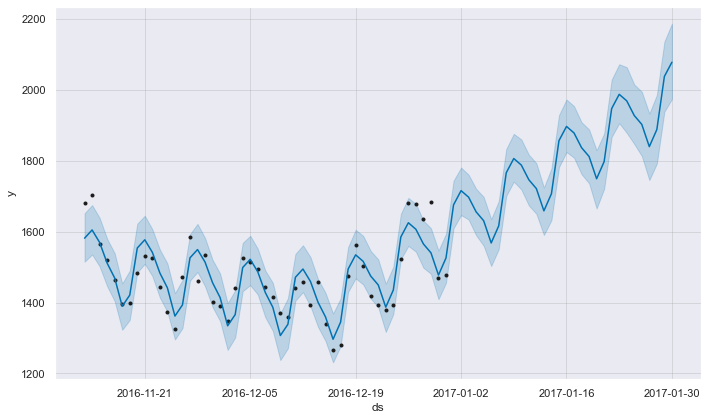

In [57]:
import seaborn as sns
sns.set(font_scale=1) 

date_index = means[['date','Visits']]
date_index = date_index.set_index('date')

prophet = date_index.copy()
prophet.reset_index(drop=False,inplace=True)
prophet.columns = ['ds','y']

m = Prophet()
m.fit(prophet)

future = m.make_future_dataframe(periods=30,freq='D')
forecast = m.predict(future)

fig = m.plot(forecast)

# 6. Conclusion

In this tutorial we analysed and forecasteed web traffic using Python and GridDB. We examined two ways to import our data, using (1) GridDB and (2) Pandas. For large datasets, GridDB provides an excellent alternative to import data in your notebook as it is open-source and highly scalable. [Download GridDB](https://griddb.net/en/downloads/) today!